In [48]:
import kagglehub
from pathlib import Path
import pandas as pd
import  torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error as RMSE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler


## Load Data

In [49]:
# Download latest version
path = kagglehub.dataset_download("mchilamwar/predict-concrete-strength")

print("Path to dataset files:", path)

path = Path(path)
data = pd.read_csv(path / "ConcreteStrengthData.csv")
data.head()

Path to dataset files: C:\Users\Nolan\.cache\kagglehub\datasets\mchilamwar\predict-concrete-strength\versions\1


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


| Колонка                     | Опис                                                                                           | Одиниці вимірювання        |
|----------------------------|------------------------------------------------------------------------------------------------|----------------------------|
| CementComponent            | Кількість цементу в суміші. Впливає на міцність та швидкість твердіння бетону.                | кг на 1 м³ бетону          |
| BlastFurnaceSlag           | Кількість доменного гранульованого шлаку як мінеральної добавки до цементу.                  | кг на 1 м³ бетону          |
| FlyAshComponent            | Кількість золошлакових відходів (fly ash), що додаються замість частини цементу.             | кг на 1 м³ бетону          |
| WaterComponent             | Об’єм води в бетонній суміші. Співвідношення вода/цемент сильно впливає на міцність бетону.   | кг (або літри) на 1 м³     |
| SuperplasticizerComponent  | Кількість суперпластифікатора — хімічної добавки, що покращує рухливість суміші без додавання води. | кг на 1 м³ бетону    |
| CoarseAggregateComponent   | Маса крупного заповнювача (щебінь, гравій) у складі бетону.                                   | кг на 1 м³ бетону          |
| FineAggregateComponent     | Маса дрібного заповнювача (пісок та подібні матеріали).                                       | кг на 1 м³ бетону          |
| AgeInDays                  | Вік зразка бетону на момент випробування на міцність.                                         | дні                         |
| Strength                   | Фактично виміряна міцність бетону на стиск для даного складу та віку.                        | МПа (megapascal, MPa)      |

## EDA

In [51]:
data.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [52]:
data.duplicated().sum()

np.int64(25)

In [53]:
df_cleaned = data.drop_duplicates(keep='first').reset_index(drop=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1005 non-null   float64
 1   BlastFurnaceSlag           1005 non-null   float64
 2   FlyAshComponent            1005 non-null   float64
 3   WaterComponent             1005 non-null   float64
 4   SuperplasticizerComponent  1005 non-null   float64
 5   CoarseAggregateComponent   1005 non-null   float64
 6   FineAggregateComponent     1005 non-null   float64
 7   AgeInDays                  1005 non-null   int64  
 8   Strength                   1005 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 70.8 KB


In [54]:
print(df_cleaned.columns.tolist())
print('CementComponent' in df_cleaned.columns)

['CementComponent ', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'Strength']
False


In [55]:
df_cleaned = df_cleaned.rename(columns={'CementComponent ': 'CementComponent'})

In [56]:
# Water–cement ratio (W/B)
df_cleaned['WaterCementRatio'] = df_cleaned['WaterComponent'] / df_cleaned['CementComponent']

# binder content
df_cleaned['BinderComponent'] = df_cleaned['CementComponent'] + df_cleaned['FlyAshComponent'] + df_cleaned['BlastFurnaceSlag']

# Water–binder ratio (W/B)
df_cleaned['WaterBinderRatio'] = df_cleaned['WaterComponent'] / df_cleaned['BinderComponent']

# The proportion of slag and ash in the binder
df_cleaned['SlagShareRatio'] = df_cleaned['BlastFurnaceSlag'] / df_cleaned['BinderComponent']
df_cleaned['AshShareRatio'] = df_cleaned['FlyAshComponent'] / df_cleaned['BinderComponent']
df_cleaned['CementShareRatio'] = df_cleaned['CementComponent'] / df_cleaned['BinderComponent']

# Superplasticizer binder ratio
df_cleaned['SuperplasticizerBinderRatio'] = df_cleaned['SuperplasticizerComponent'] / df_cleaned['BinderComponent']

# Filler ratio
df_cleaned['SuperplasticizerRatio'] = df_cleaned['BlastFurnaceSlag'] / df_cleaned['BinderComponent']
df_cleaned['FineAggregateRatio'] = df_cleaned['FineAggregateComponent'] / (df_cleaned['BinderComponent'])

# Age in days logarithm
df_cleaned['LogAgeDays'] = np.log(df_cleaned['AgeInDays'] + 1)

df_cleaned.head()
                                                                           

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,WaterCementRatio,BinderComponent,WaterBinderRatio,SlagShareRatio,AshShareRatio,CementShareRatio,SuperplasticizerBinderRatio,SuperplasticizerRatio,FineAggregateRatio,LogAgeDays
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300000,540.0,0.30000,0.0,0.0,1.0,0.00463,0.0,1.251852,3.367296
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300000,540.0,0.30000,0.0,0.0,1.0,0.00463,0.0,1.251852,3.367296
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.685714,475.0,0.48000,0.3,0.0,0.7,0.00000,0.3,1.250526,5.602119
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.685714,475.0,0.48000,0.3,0.0,0.7,0.00000,0.3,1.250526,5.902633
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.966767,331.0,0.58006,0.4,0.0,0.6,0.00000,0.4,2.493958,5.888878


## Preparation

In [57]:
X = df_cleaned.drop(columns=['Strength'])
y = df_cleaned['Strength']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Making a PyTorch Dataset

class ConcreteDataset(Dataset):
    def __init__(self, X, y):        
        # Якщо X — DataFrame, беремо .values
        # Якщо X — вже numpy, просто приводимо до масиву
        if hasattr(X, "values"):        
            self.X = X.values
        else:
            self.X = np.asarray(X)

        self.y = np.asarray(y)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset
        
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)        
        
        return X, y

train_dataset = ConcreteDataset(X_train_scaled, y_train)
test_dataset  = ConcreteDataset(X_test_scaled, y_test)

In [60]:
# Loading Batches of Data

train_dataloader = DataLoader(train_dataset,
                              batch_size=50,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=50,
                              num_workers=0
                             )

In [61]:
next(iter(train_dataloader))

[tensor([[ 2.4367e+00, -8.3766e-01, -8.7587e-01, -1.8729e+00,  3.7201e+00,
          -1.5601e+00,  1.4873e+00, -6.7904e-01, -1.5871e+00,  1.3700e+00,
          -1.6579e+00, -8.3501e-01, -8.5020e-01,  1.4853e+00,  2.8488e+00,
          -8.3501e-01, -5.7826e-01, -1.7001e+00],
         [ 1.8947e+00, -8.3766e-01, -8.7587e-01,  2.1322e+00, -1.0230e+00,
          -5.2567e-01, -2.2186e+00, -6.1485e-01, -8.9505e-01,  7.5155e-01,
           6.2173e-02, -8.3501e-01, -8.5020e-01,  1.4853e+00, -1.0652e+00,
          -8.3501e-01, -1.3095e+00, -1.0673e+00],
         [-1.0441e-02, -8.3766e-01,  6.3871e-01, -9.9937e-01,  9.6169e-01,
           1.6765e-02,  1.2635e+00, -6.7904e-01, -5.7169e-01, -3.5236e-01,
          -3.5076e-01, -8.3501e-01,  6.7103e-01,  2.4903e-01,  1.2583e+00,
          -8.3501e-01,  5.3319e-01, -1.7001e+00],
         [ 1.5193e+00, -8.3766e-01, -8.7587e-01,  1.6676e+00, -1.0230e+00,
          -1.7374e+00, -6.6425e-01, -2.7784e-01, -8.3010e-01,  3.2317e-01,
           2.2360e-01, -8

## Modeling

In [62]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
                 
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 64),
            torch.nn.ReLU(),

            nn.Linear(64, out_dim)
        )
    
    def forward(self, x):
        output = self.features(x)
        return output

In [63]:
model = LinearModel(in_dim=X_train_scaled.shape[1], out_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [64]:
num_epochs = 400

train_losses = []
train_rmses  = []
test_losses  = []
test_rmses   = []
r2_trains = []
r2_tests  = []

for epoch in range(num_epochs):
    # ========= TRAIN STEP =========
    model.train()

    y_true_train = []
    y_pred_train = []

    for inputs, targets in train_dataloader:
        # inputs: X_batch, targets: y_batch з ConcreteDataset

        # Перетворюємо в float32 (про всяк випадок)
        inputs  = inputs.float()               # форма: (batch_size, n_features)
        targets = targets.float().view(-1, 1)  # форма: (batch_size, 1)

        # Прямий прохід
        outputs = model(inputs)                # (batch_size, 1)

        # Лосс
        loss = criterion(outputs, targets)     # MSE між outputs і targets

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Збираємо прогнози і правду для метрик
        y_true_train.extend(targets.cpu().detach().numpy().ravel())
        y_pred_train.extend(outputs.cpu().detach().numpy().ravel())

    # Масиви по всій тренувальній вибірці за епоху
    y_true_train = np.array(y_true_train)
    y_pred_train = np.array(y_pred_train)

    mse_train  = mean_squared_error(y_true_train, y_pred_train)
    mae_train  = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = RMSE(y_true_train, y_pred_train)
    r2_train   = r2_score(y_true_train, y_pred_train)

    train_losses.append(mse_train)
    train_rmses.append(rmse_train)
    r2_trains.append(r2_train)

    # ========= EVAL STEP =========
    model.eval()

    y_true_test = []
    y_pred_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs  = inputs.float()
            targets = targets.float().view(-1, 1)

            outputs = model(inputs)

            y_true_test.extend(targets.cpu().detach().numpy().ravel())
            y_pred_test.extend(outputs.cpu().detach().numpy().ravel())

    y_true_test = np.array(y_true_test)
    y_pred_test = np.array(y_pred_test)

    mse_test  = mean_squared_error(y_true_test, y_pred_test)
    mae_test  = mean_absolute_error(y_true_test, y_pred_test)
    rmse_test = RMSE(y_true_test, y_pred_test)
    r2_test   = r2_score(y_true_test, y_pred_test)

    test_losses.append(mse_test)
    test_rmses.append(rmse_test)
    r2_tests.append(r2_test)

    # ========= LOG =========
    if (epoch + 1) % 100 == 0:
        print(
            f'Epoch [{epoch+1}/{num_epochs}] | '
            f'Train -> MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f} | '
            f'Test -> MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}'
        )

Epoch [100/400] | Train -> MSE: 23.5589, MAE: 3.6177, RMSE: 4.8537, R2: 0.9081 | Test -> MSE: 30.2772, MAE: 3.9754, RMSE: 5.5025, R2: 0.8985
Epoch [200/400] | Train -> MSE: 20.8526, MAE: 3.3942, RMSE: 4.5665, R2: 0.9187 | Test -> MSE: 27.7006, MAE: 3.8516, RMSE: 5.2631, R2: 0.9071
Epoch [300/400] | Train -> MSE: 19.2241, MAE: 3.2394, RMSE: 4.3845, R2: 0.9250 | Test -> MSE: 26.3845, MAE: 3.8273, RMSE: 5.1366, R2: 0.9116
Epoch [400/400] | Train -> MSE: 16.8934, MAE: 2.9979, RMSE: 4.1102, R2: 0.9341 | Test -> MSE: 24.0840, MAE: 3.6042, RMSE: 4.9075, R2: 0.9193


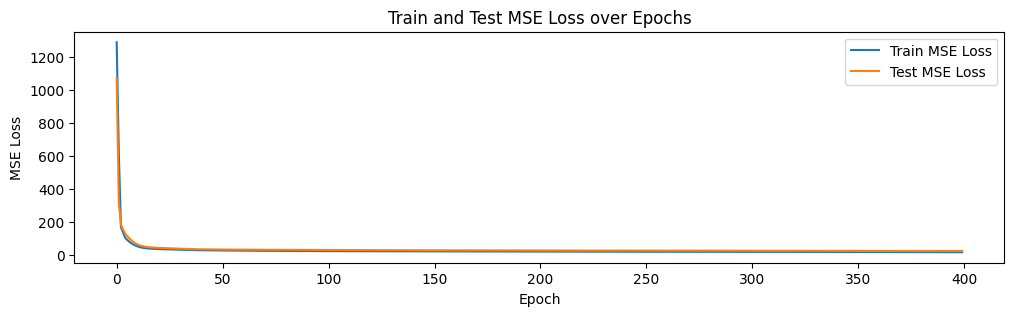

In [65]:
plt.figure(figsize=(12, 3))
plt.plot(train_losses, label='Train MSE Loss')
plt.plot(test_losses, label='Test MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train and Test MSE Loss over Epochs')
plt.legend()
plt.show()

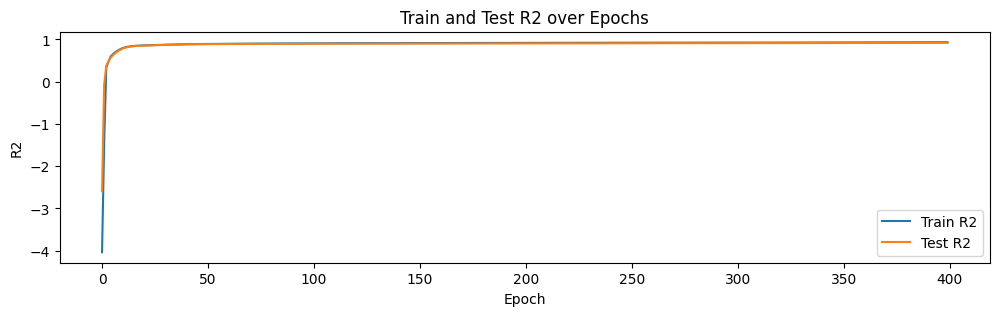

In [66]:
plt.figure(figsize=(12, 3))
plt.plot(r2_trains, label='Train R2')
plt.plot(r2_tests, label='Test R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title('Train and Test R2 over Epochs')
plt.legend()
plt.show()

Висновок:
1. Модель досягда відмінних результатів, думаю, завдяки роботоб над ознаками. Було додано декілька ознах, розрахованих на основі відомих даних.
2. Думаю модливо ще докуручувати результати, але міцінсть бетону, залежить не тільки від вказаних факторів, але й від багатьох інших, наприклад: 
- температура повітря;
- вологість;
- якщо сонячно чи поливали водою чи ні;
- технологія змішквання, послідовність змішування. 
- час транспортування. Час від виробництва до заливки;
- марка цементу.

Тобто, є багато невідомих факторів.
Я обрав достатньо просту нейромережу, тому що маємо тільки 1000 зразків, немаж сенсу 'роздувати' мережу.
Якщо чесно, здивований, що модель показала, одразу непоганий результат. 